## Imports


In [1]:
# imports
import os
import shutil
import json
import random
import kaggle
import torch
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


Matplotlib is building the font cache; this may take a moment.


## Prepare data

In [2]:
# paths
tmp_path = 'tmp'
train_dataset_path = f'{tmp_path}/train_dataset'
test_dataset_path = f'{tmp_path}/test_dataset'


In [3]:
# download dataset
if not os.path.exists(train_dataset_path) or not os.path.exists(test_dataset_path):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('grassknoted/asl-alphabet', path=tmp_path, unzip=True)

    shutil.move(f"{tmp_path}/asl_alphabet_train/asl_alphabet_train", train_dataset_path)
    shutil.move(f"{tmp_path}/asl_alphabet_test/asl_alphabet_test", test_dataset_path)

    shutil.rmtree(f"{tmp_path}/asl_alphabet_train")
    shutil.rmtree(f"{tmp_path}/asl_alphabet_test")


## Configure PyTorch


In [4]:
# PyTorch device
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Prepare data


In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform


Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
# Load dataset
dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
dataset


Dataset ImageFolder
    Number of datapoints: 87000
    Root location: tmp/train_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
# Get classes
classes = dataset.classes
classes


['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [8]:
# Count classes
classes_count = len(classes)
classes_count


29

In [9]:
# Set train/test split ratio
train_ratio = 0.8
test_ratio = 0.2
{"train_ratio": train_ratio, "test_ratio": test_ratio}


{'train_ratio': 0.8, 'test_ratio': 0.2}

In [10]:
# Set train/test sizes
train_size = int(train_ratio * len(dataset))
test_size = int(test_ratio * len(dataset))
{"train_size": train_size, "test_size": test_size}


{'train_size': 69600, 'test_size': 17400}

In [11]:
# Split dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [12]:
# Count train/test dataset sizes
train_dataset_count = len(train_dataset)
test_dataset_count = len(test_dataset)
{"train_dataset_count": train_dataset_count, "test_dataset_count": test_dataset_count}


{'train_dataset_count': 69600, 'test_dataset_count': 17400}

In [13]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [14]:
# Display random images function
def show_random_samples(dataset, classes, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))

    for i in range(num_samples):
        index = np.random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].set_title(classes[label])
        axs[i].axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


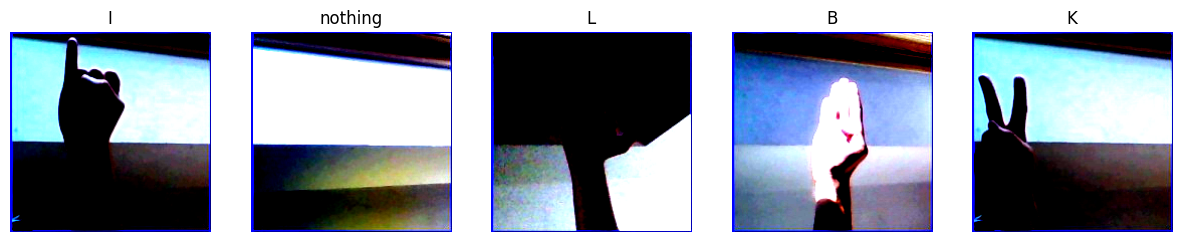

In [15]:
# Display random images from train dataset
show_random_samples(train_dataset, classes)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


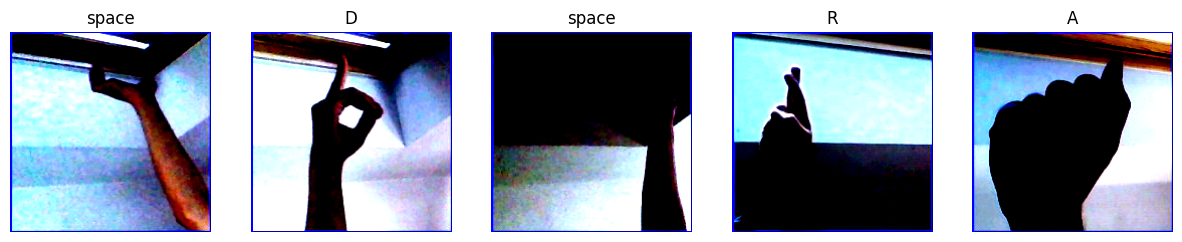

In [16]:
# Display random images from test dataset
show_random_samples(test_dataset, classes)


## Prepare models


### Make models folder

In [17]:
os.makedirs('tmp/models', exist_ok=True)


## Make model losses folder


In [18]:
os.makedirs('tmp/model_losses', exist_ok=True)


### AlexNet


In [19]:
AlexNet_model = models.alexnet()

# Freeze model parameters
for param in AlexNet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
AlexNet_model.classifier[6] = torch.nn.Linear(AlexNet_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
AlexNet_model.to(device)

# Define loss function and optimizer
AlexNet_model_criterion = torch.nn.CrossEntropyLoss()
AlexNet_model_optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=0.001)


In [20]:
summary(AlexNet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 49, 49]          23,296
              ReLU-2           [-1, 64, 49, 49]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 192, 24, 24]         307,392
              ReLU-5          [-1, 192, 24, 24]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

### GoogleNet


In [21]:
GoogleNet_model = models.googlenet(models.GoogLeNet_Weights.DEFAULT)

# Freeze model parameters
for param in GoogleNet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
GoogleNet_model.fc = torch.nn.Linear(GoogleNet_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
GoogleNet_model.to(device)

# Define loss function and optimizer
GoogleNet_model_criterion = torch.nn.CrossEntropyLoss()
GoogleNet_model_optimizer = torch.optim.Adam(GoogleNet_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/rbrauner/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:04<00:00, 11.6MB/s]


In [22]:
summary(GoogleNet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
       BasicConv2d-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
       BasicConv2d-7           [-1, 64, 50, 50]               0
            Conv2d-8          [-1, 192, 50, 50]         110,592
       BatchNorm2d-9          [-1, 192, 50, 50]             384
      BasicConv2d-10          [-1, 192, 50, 50]               0
        MaxPool2d-11          [-1, 192, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          12,288
      BatchNorm2d-13           [-1, 64, 25, 25]             128
      BasicConv2d-14           [-1, 64,

### MobileNet V2


In [23]:
# MobileNetV2_model = models.MobileNetV2()

# # Freeze model parameters
# for param in MobileNetV2_model.parameters():
#     param.requires_grad = False

# # Modify the last fully connected layer to fit your number of classes
# MobileNetV2_model.classifier[6] = torch.nn.Linear(MobileNetV2_model.classifier[6].in_features, classes_count)

# # Move the model to the device (GPU if available)
# MobileNetV2_model.to(device)

# # Define loss function and optimizer
# MobileNetV2_model_criterion = torch.nn.CrossEntropyLoss()
# MobileNetV2_model_optimizer = torch.optim.Adam(MobileNetV2_model.parameters(), lr=0.001)


In [24]:
# summary(MobileNetV2_model, input_size=(3, 200, 200))


### MobileNet V3


In [25]:
# MobileNetV3_model = models.MobileNetV3()

# # Freeze model parameters
# for param in MobileNetV3_model.parameters():
#     param.requires_grad = False

# # Modify the last fully connected layer to fit your number of classes
# MobileNetV3_model.classifier[6] = torch.nn.Linear(MobileNetV3_model.classifier[6].in_features, classes_count)

# # Move the model to the device (GPU if available)
# MobileNetV3_model.to(device)

# # Define loss function and optimizer
# MobileNetV3_model_criterion = torch.nn.CrossEntropyLoss()
# MobileNetV3_model_optimizer = torch.optim.Adam(MobileNetV3_model.parameters(), lr=0.001)


In [26]:
# summary(MobileNetV3_model, input_size=(3, 200, 200))


### ResNet 18


In [27]:
ResNet18_model = models.resnet18()

# Freeze model parameters
for param in ResNet18_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
ResNet18_model.fc = torch.nn.Linear(ResNet18_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
ResNet18_model.to(device)

# Define loss function and optimizer
ResNet18_model_criterion = torch.nn.CrossEntropyLoss()
ResNet18_model_optimizer = torch.optim.Adam(ResNet18_model.parameters(), lr=0.001)


In [28]:
summary(ResNet18_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

### ResNet 50


In [29]:
ResNet50_model = models.resnet50()

# Freeze model parameters
for param in ResNet50_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
ResNet50_model.fc = torch.nn.Linear(ResNet50_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
ResNet50_model.to(device)

# Define loss function and optimizer
ResNet50_model_criterion = torch.nn.CrossEntropyLoss()
ResNet50_model_optimizer = torch.optim.Adam(ResNet50_model.parameters(), lr=0.001)


In [30]:
summary(ResNet50_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

### Vgg16


In [31]:
Vgg16_model = models.vgg16()

# Freeze model parameters
for param in Vgg16_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
Vgg16_model.classifier[6] = torch.nn.Linear(Vgg16_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
Vgg16_model.to(device)

# Define loss function and optimizer
Vgg16_model_criterion = torch.nn.CrossEntropyLoss()
Vgg16_model_optimizer = torch.optim.Adam(Vgg16_model.parameters(), lr=0.001)


In [32]:
summary(Vgg16_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

### Vgg19


In [33]:
Vgg19_model = models.vgg16()

# Freeze model parameters
for param in Vgg19_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
Vgg19_model.classifier[6] = torch.nn.Linear(Vgg19_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
Vgg19_model.to(device)

# Define loss function and optimizer
Vgg19_model_criterion = torch.nn.CrossEntropyLoss()
Vgg19_model_optimizer = torch.optim.Adam(Vgg19_model.parameters(), lr=0.001)


In [34]:
summary(Vgg19_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

### Custom


## Train models


In [35]:
# train model function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    epochs_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        epochs_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epochs_losses


### AlexNet


In [36]:
AlexNet_model_losses = None
model_path = 'tmp/models/ASL_AlexNet_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_AlexNet_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    AlexNet_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        AlexNet_model_losses = json.load(filehandle)
else:
    AlexNet_model_losses = train_model(AlexNet_model, train_loader, AlexNet_model_criterion, AlexNet_model_optimizer, device, num_epochs=10)
    torch.save(AlexNet_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(AlexNet_model_losses, filehandle)


/tmp/ipykernel_17332/4078207358.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  AlexNet_model = torch.load(model_path)


In [37]:
AlexNet_model_losses


[3.3359750007760938,
 3.2868938556758835,
 3.254464733956874,
 3.227686857903141,
 3.2068073042507828,
 3.1876751477690948,
 3.1705563032216038,
 3.1564471135194276,
 3.1416036286847344,
 3.1283197047792632]

### GoogleNet


In [38]:
GoogleNet_model_losses = None
model_path = 'tmp/models/ASL_GoogleNet_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_GoogleNet_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    GoogleNet_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        GoogleNet_model_losses = json.load(filehandle)
else:
    GoogleNet_model_losses = train_model(GoogleNet_model, train_loader, GoogleNet_model_criterion, GoogleNet_model_optimizer, device, num_epochs=10)
    torch.save(GoogleNet_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(GoogleNet_model_losses, filehandle)


/tmp/ipykernel_17332/1472256004.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GoogleNet_model = torch.load(model_path)


In [39]:
GoogleNet_model_losses


[0.7923016272536639,
 0.3358603435583498,
 0.27094705465196195,
 0.24122620480841603,
 0.2319349822573278,
 0.2167101205979613,
 0.2124257630786334,
 0.20576974114124802,
 0.20216896911719065,
 0.19896673297231224]

### MobileNet V2


In [40]:
# MobileNetV2_model_losses = None
# model_path = 'tmp/models/ASL_MobileNetV2_model_V1.0.0.pth'
# model_losses_path = 'tmp/model_losses/ASL_MobileNetV2_model_losses_V1.0.0.json'
# 
# if os.path.isfile(model_path):
#     MobileNetV2_model = torch.load(model_path)
# 
#     with open(model_losses_path) as filehandle:
#         MobileNetV2_model_losses = json.load(filehandle)
# else:
#     MobileNetV2_model_losses = train_model(MobileNetV2_model, train_loader, MobileNetV2_model_criterion, MobileNetV2_model_optimizer, device, num_epochs=10)
#     torch.save(MobileNetV2_model, model_path)
# 
#     with open(model_losses_path, 'w') as filehandle:
#         json.dump(MobileNetV2_model_losses, filehandle)


In [41]:
# MobileNetV2_model_losses


### MobileNet V3


In [42]:
# MobileNetV3_model_losses = None
# model_path = 'tmp/models/ASL_MobileNetV3_model_V1.0.0.pth'
# model_losses_path = 'tmp/model_losses/ASL_MobileNetV3_model_losses_V1.0.0.json'
# 
# if os.path.isfile(model_path):
#     MobileNetV3_model = torch.load(model_path)
# 
#     with open(model_losses_path) as filehandle:
#         MobileNetV3_model_losses = json.load(filehandle)
# else:
#     MobileNetV3_model_losses = train_model(MobileNetV3_model, train_loader, MobileNetV3_model_criterion, MobileNetV3_model_optimizer, device, num_epochs=10)
#     torch.save(MobileNetV3_model, model_path)
# 
#     with open(model_losses_path, 'w') as filehandle:
#         json.dump(MobileNetV3_model_losses, filehandle)


In [43]:
# MobileNetV3_model_losses


### ResNet 18


In [44]:
ResNet18_model_losses = None
model_path = 'tmp/models/ASL_ResNet18_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_ResNet18_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    ResNet18_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        ResNet18_model_losses = json.load(filehandle)
else:
    ResNet18_model_losses = train_model(ResNet18_model, train_loader, ResNet18_model_criterion, ResNet18_model_optimizer, device, num_epochs=10)
    torch.save(ResNet18_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(ResNet18_model_losses, filehandle)


/tmp/ipykernel_17332/2969148049.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ResNet18_model = torch.load(model_path)


In [45]:
ResNet18_model_losses


[3.0488622390264752,
 2.6016368850072227,
 2.339406366622311,
 2.154723244919174,
 2.018670006456046,
 1.912053126192641,
 1.825718586965539,
 1.7507426060753306,
 1.687544457282143,
 1.6353598319525007]

### ResNet 50


In [46]:
ResNet50_model_losses = None
model_path = 'tmp/models/ASL_ResNet50_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_ResNet50_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    ResNet50_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        ResNet50_model_losses = json.load(filehandle)
else:
    ResNet50_model_losses = train_model(ResNet50_model, train_loader, ResNet50_model_criterion, ResNet50_model_optimizer, device, num_epochs=10)
    torch.save(ResNet50_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(ResNet50_model_losses, filehandle)


/tmp/ipykernel_17332/2992874523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ResNet50_model = torch.load(model_path)


In [47]:
ResNet50_model_losses


[3.3468441212314297,
 2.892827894386204,
 2.617551605016336,
 2.432728089518931,
 2.2967000583670605,
 2.215279701441184,
 2.1256081685252575,
 2.0582952606815033,
 2.009901752033453,
 1.9547103526674467]

### Vgg16


In [48]:
Vgg16_model_losses = None
model_path = 'tmp/models/ASL_Vgg16_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_Vgg16_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    Vgg16_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        Vgg16_model_losses = json.load(filehandle)
else:
    Vgg16_model_losses = train_model(Vgg16_model, train_loader, Vgg16_model_criterion, Vgg16_model_optimizer, device, num_epochs=10)
    torch.save(Vgg16_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(Vgg16_model_losses, filehandle)


Epoch 1/10, Loss: 3.2518
Epoch 2/10, Loss: 3.1078
Epoch 3/10, Loss: 3.0343
Epoch 4/10, Loss: 2.9906
Epoch 5/10, Loss: 2.9586
Epoch 6/10, Loss: 2.9412
Epoch 7/10, Loss: 2.9207
Epoch 8/10, Loss: 2.9113
Epoch 9/10, Loss: 2.8956
Epoch 10/10, Loss: 2.8907


In [49]:
Vgg16_model_losses


[3.2517616985584126,
 3.107810601968875,
 3.034263639888544,
 2.9905968663884304,
 2.958649457186118,
 2.941178780698228,
 2.920728112911356,
 2.9112937031669177,
 2.895607093613723,
 2.8907437826573164]

### Vgg19


In [50]:
Vgg19_model_losses = None
model_path = 'tmp/models/ASL_Vgg19_model_V1.0.0.pth'
model_losses_path = 'tmp/model_losses/ASL_Vgg19_model_losses_V1.0.0.json'

if os.path.isfile(model_path):
    Vgg19_model = torch.load(model_path)

    with open(model_losses_path) as filehandle:
        Vgg19_model_losses = json.load(filehandle)
else:
    Vgg19_model_losses = train_model(Vgg19_model, train_loader, Vgg19_model_criterion, Vgg19_model_optimizer, device, num_epochs=10)
    torch.save(Vgg19_model, model_path)

    with open(model_losses_path, 'w') as filehandle:
        json.dump(Vgg19_model_losses, filehandle)


Epoch 1/10, Loss: 3.2140
Epoch 2/10, Loss: 3.0510
Epoch 3/10, Loss: 2.9749
Epoch 4/10, Loss: 2.9331
Epoch 5/10, Loss: 2.9045
Epoch 6/10, Loss: 2.8806
Epoch 7/10, Loss: 2.8632
Epoch 8/10, Loss: 2.8463
Epoch 9/10, Loss: 2.8439
Epoch 10/10, Loss: 2.8332


In [51]:
Vgg19_model_losses


[3.213971840211715,
 3.051010123724225,
 2.974899961318093,
 2.9330778336799006,
 2.9044920863228283,
 2.8806046074834364,
 2.8631773362214537,
 2.846315928382435,
 2.843897694225969,
 2.833175481379717]

### Custom


In [52]:
# Custom_model_losses = None
# model_path = 'tmp/models/ASL_Custom_model_V1.0.0.pth'
# model_losses_path = 'tmp/model_losses/ASL_Custom_model_losses_V1.0.0.json'
# 
# if os.path.isfile(model_path):
#     Custom_model = torch.load(model_path)
# 
#     with open(model_losses_path) as filehandle:
#         Custom_model_losses = json.load(filehandle)
# else:
#     Custom_model_losses = train_model(Custom_model, train_loader, Custom_model_criterion, Custom_model_optimizer, device, num_epochs=10)
#     torch.save(Custom_model, model_path)
# 
#     with open(model_losses_path, 'w') as filehandle:
#         json.dump(Custom_model_losses, filehandle)


In [53]:
# Custom_model_losses


### Losses plot


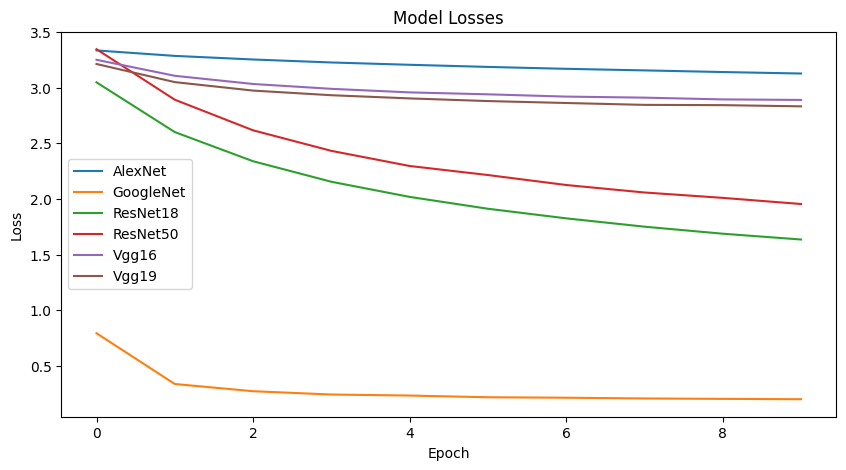

In [54]:
all_losses = [
    AlexNet_model_losses,
    GoogleNet_model_losses,
    # MobileNetV2_model_losses,
    # MobileNetV3_model_losses,
    ResNet18_model_losses,
    ResNet50_model_losses,
    Vgg16_model_losses,
    Vgg19_model_losses,
    # Custom_model_losses,
]

plt.figure(figsize=(10, 5))
for losses in all_losses:
    plt.plot(losses)
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
    "AlexNet",
    "GoogleNet",
    # "MobileNetV2",
    # "MobileNetV3",
    "ResNet18",
    "ResNet50",
    "Vgg16",
    "Vgg19",
    # "Custom",
])
plt.show()


## Evaluate


In [55]:
# test model function
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


### AlexNet


In [56]:
# test the model
AlexNet_model_accuracy = test_model(AlexNet_model, test_loader, AlexNet_model_criterion, device)


Test Accuracy: 5.98%


### GoogleNet


In [57]:
# test the model
GoogleNet_model_accuracy = test_model(GoogleNet_model, test_loader, GoogleNet_model_criterion, device)


Test Accuracy: 97.77%


### MobileNet V2


In [58]:
# test the model
# MobileNetV2_model_accuracy = test_model(MobileNetV2_model, test_loader, MobileNetV2_model_criterion, device)


### MobileNet V3


In [59]:
# test the model
# MobileNetV3_model_accuracy = test_model(MobileNetV3_model, test_loader, MobileNetV3_model_criterion, device)


### ResNet 18


In [60]:
# test the model
ResNet18_model_accuracy = test_model(ResNet18_model, test_loader, ResNet18_model_criterion, device)


Test Accuracy: 56.15%


### ResNet 50


In [61]:
# test the model
ResNet50_model_accuracy = test_model(ResNet50_model, test_loader, ResNet50_model_criterion, device)


Test Accuracy: 47.27%


### Vgg16


In [62]:
# test the model
Vgg16_model_accuracy = test_model(Vgg16_model, test_loader, Vgg16_model_criterion, device)


Test Accuracy: 25.63%


### Vgg19


In [63]:
# test the model
Vgg19_model_accuracy = test_model(Vgg19_model, test_loader, Vgg19_model_criterion, device)


Test Accuracy: 30.53%


### Custom


In [64]:
# test the model
# Custom_model_accuracy = test_model(Custom_model, test_loader, Custom_model_criterion, device)


### Summary


In [65]:
# Create a dictionary to store results
model_results = {
    "Model": [
        "AlexNet",
        "GoogleNet",
        # "MobileNetV2",
        # "MobileNetV3",
        "ResNet18",
        "ResNet50",
        "Vgg16",
        "Vgg19",
        # "Custom",
    ],
    "Loss": [
        AlexNet_model_losses[-1],
        GoogleNet_model_losses[-1],
        # MobileNetV2_model_losses[-1],
        # MobileNetV3_model_losses[-1],
        ResNet18_model_losses[-1],
        ResNet50_model_losses[-1],
        Vgg16_model_losses[-1],
        Vgg19_model_losses[-1],
        # Custom_model_losses[-1],
    ],
    "Accuracy": [
        AlexNet_model_accuracy,
        GoogleNet_model_accuracy,
        # MobileNetV2_model_accuracy,
        # MobileNetV3_model_accuracy,
        ResNet18_model_accuracy,
        ResNet50_model_accuracy,
        Vgg16_model_accuracy,
        Vgg19_model_accuracy,
        # Custom_model_accuracy,
    ]
}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(model_results)

# Print the DataFrame as a table
print(df.to_string())


       Model      Loss   Accuracy
0    AlexNet  3.128320   5.977011
1  GoogleNet  0.198967  97.770115
2   ResNet18  1.635360  56.149425
3   ResNet50  1.954710  47.270115
4      Vgg16  2.890744  25.626437
5      Vgg19  2.833175  30.528736


## Test


In [66]:
# predict and display image function
def predict_and_display_image(model, image_path, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Make a prediction
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = classes[predicted.item()]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} - {model.__class__.__name__}")
    plt.axis('off')
    plt.show()


In [67]:
images_paths = [
    'tmp/test_g.jpeg',
    'tmp/test_dataset/G_test.jpg',
]


### AlexNet


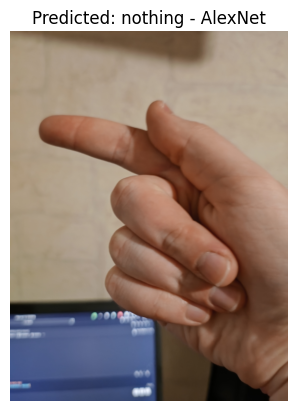

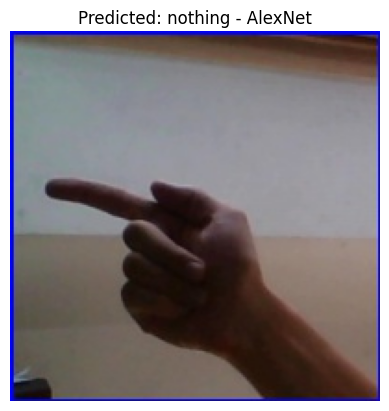

In [68]:
for image_path in images_paths:
    predict_and_display_image(AlexNet_model, image_path, transform, device)


### GoogleNet


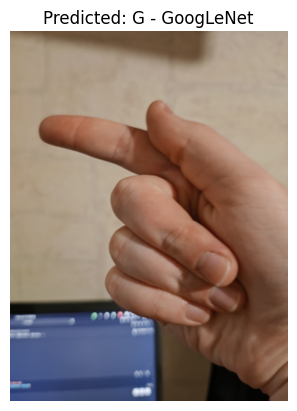

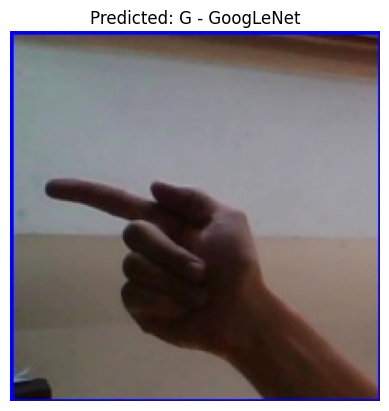

In [69]:
for image_path in images_paths:
    predict_and_display_image(GoogleNet_model, image_path, transform, device)


### MobileNet V2


In [70]:
# for image_path in images_paths:
#     predict_and_display_image(MobileNetV2_model, image_path, transform, device)


### MobileNet V3


In [71]:
# for image_path in images_paths:
#     predict_and_display_image(MobileNetV3_model, image_path, transform, device)


### ResNet 18


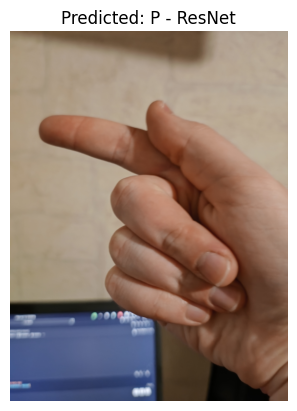

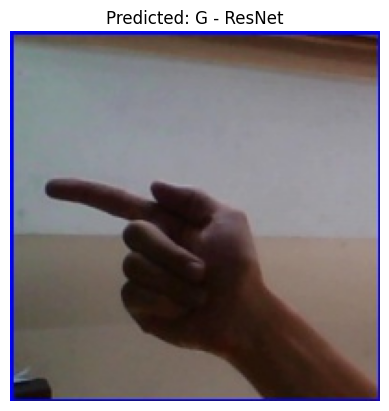

In [72]:
for image_path in images_paths:
    predict_and_display_image(ResNet18_model, image_path, transform, device)


### ResNet 50


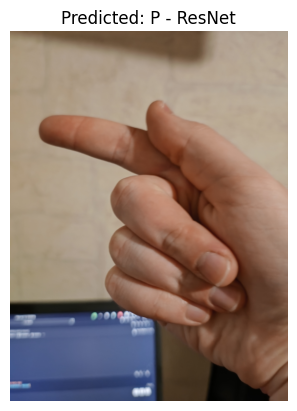

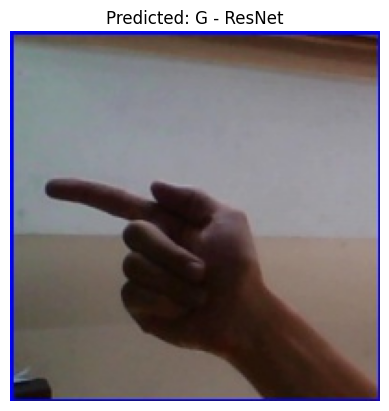

In [73]:
for image_path in images_paths:
    predict_and_display_image(ResNet50_model, image_path, transform, device)


### Vgg16


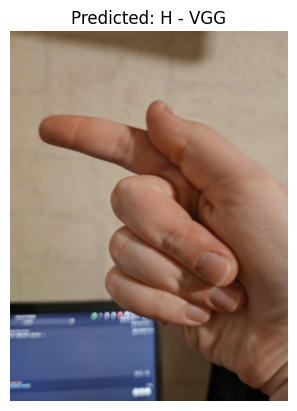

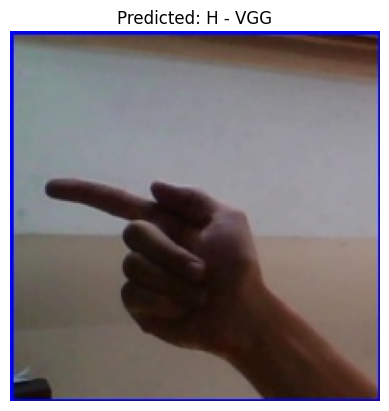

In [74]:
for image_path in images_paths:
    predict_and_display_image(Vgg16_model, image_path, transform, device)


### Vgg19


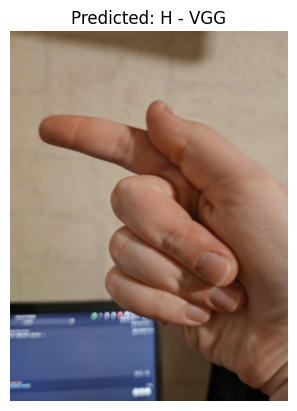

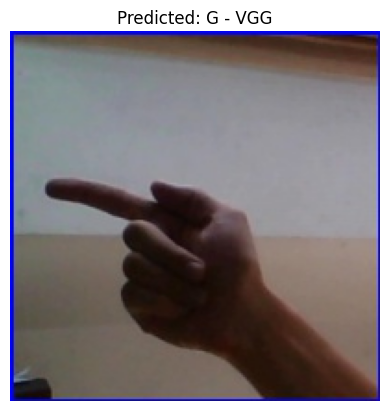

In [75]:
for image_path in images_paths:
    predict_and_display_image(Vgg19_model, image_path, transform, device)


### Custom


In [76]:
# for image_path in images_paths:
#     predict_and_display_image(Custom_model, image_path, transform, device)
